# Import the necessary dependencies 

### Setting TensorFlow 2.x as default version 

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

### Importing the Visualisation and Preprocessing packages

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

import numpy as np
import pandas as pd
import pickle

import random


### Importing the TensorFlow dependencies

In [5]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Data loading and Visualisation 

### Loading the data

In [10]:
#data = pd.read_csv("german-traffic-signs / signnames.csv") 
  
with open('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


### Visualising the Image data

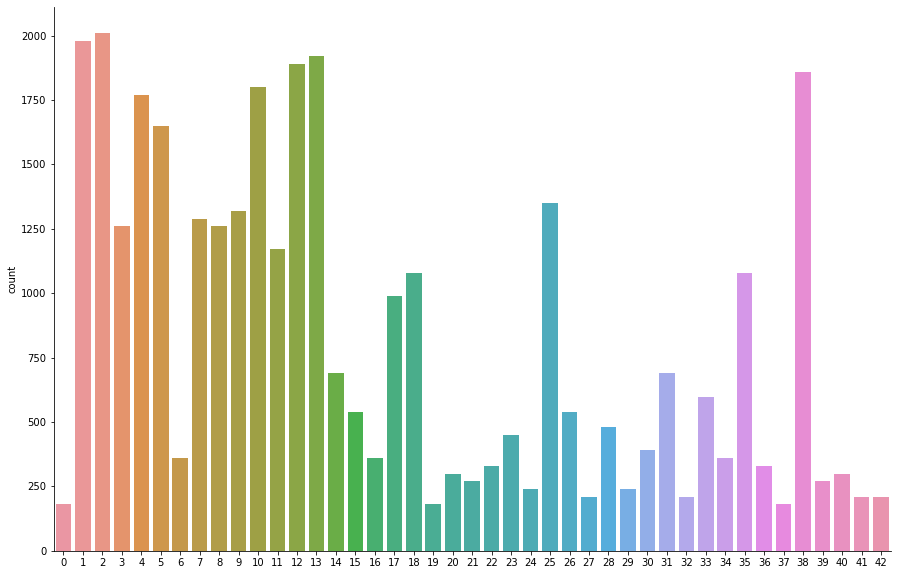

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(x="labels", data=train_data)
sns.despine()

# Image Processing & Image Augmentation

### Pre-processing the images using OpenCV

In [12]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 


### Image Augmentation using ImageDataGenerator

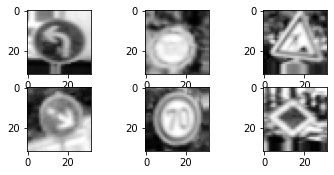

In [14]:

datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

#os.makedirs('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/images')

for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir='C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/images',save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 


# Model Building and Testing 

### Implementing the CNN Model 

In [15]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

### Install Kerastuner

In [16]:
!pip install keras-tuner

### Use RandomSearch using keraatuner to find the best hyperparameters

In [19]:
from kerastuner import RandomSearch

In [20]:
tuner = RandomSearch(build_model, objective='val_accuracy',
                     max_trials = 10, 
                     directory='C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/',
                     project_name="Traffic_Sign_Classifier")

INFO:tensorflow:Reloading Tuner from C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier\tuner0.json


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
CONV_1_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
KERNEL_1_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
CONV_2_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
KERNEL_2_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
CONV_3_FILTER (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
KERNEL_3_FILTER (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
DROPOUT_3 (Float)
{'default': 0.25, 'conditions

In [22]:
tuner.search(x_train_final,y_train,epochs=10, validation_data=(x_val_final,y_val))

INFO:tensorflow:Oracle triggered exit


### Get the best model

In [23]:
final_model = tuner.get_best_models(num_models=1)[0]

In [24]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 40)        400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 40)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 41)        14801     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 41)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 41)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 102)         1

### Creating a Model Checkpoint

In [25]:
filepath="C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

### Fit the model

In [26]:
BATCH_SIZE = 100
EPOCHS = 40

In [27]:
history = final_model.fit(
                            datagen.flow(x_train_final, y_train, batch_size=BATCH_SIZE), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(BATCH_SIZE))), 
                            epochs = EPOCHS, 
                            validation_data =(x_val_final, y_val),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )


Epoch 1/40
348/348 [==============================] - 84s 234ms/step - loss: 0.8683 - accuracy: 0.7665 - val_loss: 0.3029 - val_accuracy: 0.9429

Epoch 00001: val_accuracy improved from -inf to 0.94286, saving model to C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset\Traffic_Sign_Classifier_CNN.hdf5
Epoch 2/40
348/348 [==============================] - 80s 229ms/step - loss: 0.6387 - accuracy: 0.8328 - val_loss: 0.2793 - val_accuracy: 0.9449

Epoch 00002: val_accuracy improved from 0.94286 to 0.94490, saving model to C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset\Traffic_Sign_Classifier_CNN.hdf5
Epoch 3/40
348/348 [==============================] - 80s 230ms/step - loss: 0.5555 - accuracy: 0.8575 - val_loss: 0.2723 - val_accuracy: 0.9481

Epoch 00003: val_accuracy improved from 0.94490 to 0.94807, saving model to C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classi

348/348 [==============================] - 90s 260ms/step - loss: 0.2925 - accuracy: 0.9387 - val_loss: 0.2354 - val_accuracy: 0.9544

Epoch 00035: val_accuracy did not improve from 0.97007
Epoch 36/40
348/348 [==============================] - 90s 258ms/step - loss: 0.2968 - accuracy: 0.9387 - val_loss: 0.2404 - val_accuracy: 0.9587

Epoch 00036: val_accuracy did not improve from 0.97007
Epoch 37/40
348/348 [==============================] - 80s 230ms/step - loss: 0.2899 - accuracy: 0.9402 - val_loss: 0.2283 - val_accuracy: 0.9603

Epoch 00037: val_accuracy did not improve from 0.97007
Epoch 38/40
348/348 [==============================] - 75s 215ms/step - loss: 0.2897 - accuracy: 0.9419 - val_loss: 0.2203 - val_accuracy: 0.9673

Epoch 00038: val_accuracy did not improve from 0.97007
Epoch 39/40
348/348 [==============================] - 70s 200ms/step - loss: 0.2856 - accuracy: 0.9419 - val_loss: 0.2170 - val_accuracy: 0.9624

Epoch 00039: val_accuracy did not improve from 0.97007
Ep

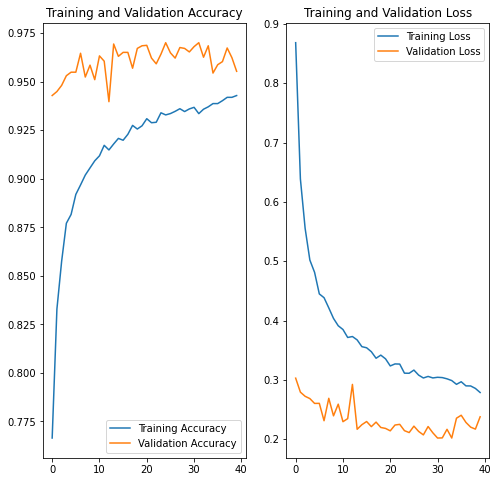

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load the model's weights and biases for evaluation on Test set

In [29]:
final_model.load_weights("C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5")
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
Pred_conv = final_model.evaluate(x_test_final, y_test, verbose=0)
print("Results on the test data")
print(" ")
print("%s- %.2f" % (final_model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (final_model.metrics_names[1], Pred_conv[1]))

Results on the test data
 
loss- 0.32
accuracy- 0.94


### Testing the model on the test dataset

Predicted sign: [[4.0628718e-09 1.1376587e-05 2.9835324e-08 1.5260440e-08 1.3443575e-12
  4.4860885e-06 9.9998379e-01 1.8541707e-09 4.2306059e-12 8.7551243e-14
  3.7222714e-11 2.2333555e-09 6.0753399e-12 5.7752999e-12 1.2898732e-12
  4.5159562e-15 7.1424651e-11 9.1279775e-16 2.8872466e-12 1.4245691e-15
  1.4459567e-12 5.5607855e-11 5.7841676e-18 7.3222434e-14 1.3224867e-14
  4.4598106e-12 1.2106407e-15 8.7812223e-12 6.0129068e-11 5.9523317e-13
  1.8348074e-09 2.8304425e-11 6.0471670e-08 8.9709126e-12 2.0767517e-12
  3.4259446e-12 3.5202639e-12 1.4041992e-11 1.1364387e-09 2.0582765e-12
  2.4488817e-10 1.0515231e-09 2.8204138e-07]]
---------------------------------------------------------------------------
Predicted Sign[0]


C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


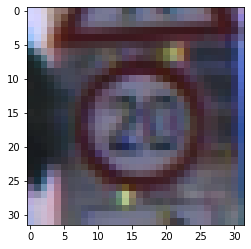

In [31]:

plt.imshow(x_test[990]) 
print("Predicted sign: "+ str( 
        final_model.predict(x_test_final[1700].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(final_model.predict_classes(x_test_final[990].reshape(1, 32, 32, 1))))


### Save the model

In [32]:
final_model.save('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

### Loading the saved model 

In [33]:
loaded_model = tf.keras.models.load_model('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 40)        400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 40)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 41)        14801     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 41)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 41)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 102)         1

### Making predictions with the loaded model 

Predicted sign: [[2.37549489e-06 8.28947406e-03 3.67292650e-02 2.66231745e-02
  5.96170548e-06 9.26149964e-01 3.30996158e-06 1.96155324e-03
  2.14008440e-04 2.44305198e-07 1.87295827e-05 1.79606108e-08
  5.09676852e-08 1.37772294e-09 8.91999008e-09 1.03921085e-08
  7.82148291e-10 6.94968458e-11 3.76281402e-11 1.56976532e-11
  5.95806127e-10 8.01913380e-09 3.94921454e-14 1.03429331e-11
  1.57983891e-12 1.15592209e-10 5.37037151e-11 2.82769003e-10
  5.52382007e-09 1.65747627e-09 2.54259085e-08 1.26545652e-09
  2.93931475e-08 1.33528644e-09 1.34693534e-09 1.99728167e-09
  9.62035007e-10 1.57644123e-11 7.59091506e-07 2.07227319e-10
  5.63561571e-07 6.03267492e-10 4.13785642e-07]]
---------------------------------------------------------------------------
Predicted Sign[5]


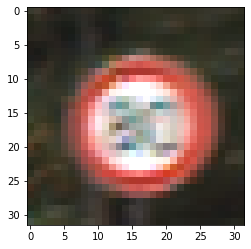

In [34]:
plt.imshow(x_test[1832]) 
print("Predicted sign: "+ str( 
        loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(loaded_model.predict_classes(x_test_final[1832].reshape(1, 32, 32, 1))))

### Testing our saved model on random traffic sign images





In [36]:
from tensorflow.keras.models import load_model

import cv2

import numpy as np

final_model = load_model('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

img = cv2.imread('C:/Users/Hp/Desktop/Traffic_Sign_Classifier/Traffic_Sign_Classifier-with-Streamlit/Traffic_sign_Dataset/images/img_19225_1460.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = final_model.predict_classes(img)

print(classes)

[35]
